In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate, GlobalAvgPool2D
from tensorflow.keras.models import Model

# pretrained model: ResNet50
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight


In [2]:
def parse_spectrogram_and_metadata(melspec_path, split_path, metadata_path):
    # Load mel spectrograms
    melspec_dict = np.load(melspec_path, allow_pickle=True).item()

    # Load split and label info
    split_df = pd.read_csv(split_path)
    split_df['key'] = split_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    split_df = split_df.set_index('key')

    # Load downsampled metadata
    meta_df = pd.read_csv(metadata_path)
    meta_df['key'] = meta_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    meta_df = meta_df.set_index('key')

    X_img, X_meta, y, splits = [], [], [], []

    for key in meta_df.index:
        if key not in melspec_dict or key not in split_df.index:
            continue

        img = melspec_dict[key]
        info = split_df.loc[key]
        meta_row = meta_df.loc[key]

        metadata = np.array([
            float(meta_row['latitude']),
            float(meta_row['longitude']),
            float(meta_row['call']),
            float(meta_row['song/canto'])
        ], dtype=np.float32)

        X_img.append(img)
        X_meta.append(metadata)
        y.append(info['y_species_encoded'])
        splits.append(info['split'])

    return np.array(X_img), np.array(X_meta), np.array(y), np.array(splits)

In [3]:
def split_data(X_img, X_meta, y, splits):
    split_map = defaultdict(lambda: ([], [], []))

    for i, split in enumerate(splits):
        split_map[split][0].append(X_img[i])
        split_map[split][1].append(X_meta[i])
        split_map[split][2].append(y[i])

    def to_np(t): return tuple(map(np.array, t))
    return {k: to_np(v) for k, v in split_map.items()}

In [4]:
# data augmentation
def add_random_noise(mels, noise_factor=0.05):
    noise = noise_factor * np.random.randn(*mels.shape)
    return np.clip(mels + noise, 0.0, 1.0).astype(np.float32)

def time_mask(spec, max_width=8):
    t = np.random.randint(0, spec.shape[1] - max_width)
    width = np.random.randint(1, max_width)
    spec[:, t:t+width] = 0
    return spec

def freq_mask(spec, max_height=4):
    f = np.random.randint(0, spec.shape[0] - max_height)
    height = np.random.randint(1, max_height)
    spec[f:f+height, :] = 0
    return spec


def augment_spectrogram(spec):
    spec = add_random_noise(spec)
    spec = time_mask(spec)
    spec = freq_mask(spec)
    spec = spec.astype(np.float32)

    return spec

def image_augment(spec):
    spec = tf.image.random_brightness(spec, max_delta = .1)
    spec = tf.image.random_contrast(spec, .9, 1.1)

    return spec



In [5]:
X_img, X_meta, y, splits = parse_spectrogram_and_metadata(
    # getting 256 data since pretrained model expects large sizes
    melspec_path= "../data/32/birdclef2025_melspec_5sec_32_32.npy",
    split_path= "../data/work_df_w_split_info.csv",
    metadata_path="../data/downsampled_metadata.csv"
)

In [6]:
# resizing image for inceptionv3
IMG_SIZE = 224

In [7]:
def preprocess_spec(img):
    img = tf.cast(img, tf.float32)
    img = img[..., tf.newaxis] # to get (32, 32, 1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) #(224, 224, 1)
    img = tf.image.grayscale_to_rgb(img) # now (224, 224, 3)

    return img


In [8]:
def make_tf_dataset(X_img, X_meta, y, batch_size = 32, augment = False, shuffle = True):
    def map_fn(img, meta, label):
        if augment:
            # augment before resizing
            img = tf.numpy_function(augment_spectrogram, [img], tf.float32)
            img.set_shape([32, 32])

        img = preprocess_spec(img)

        # augmenting after resizing
        if augment:
            img = image_augment(img)

        return({"image": img, "metadata": meta}, tf.one_hot(label, num_classes))
    
    ds = tf.data.Dataset.from_tensor_slices((X_img, X_meta, y))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(X_img))
        if shuffle:
            ds = ds.shuffle(buffer_size = len(X_img))
        
    ds = ds.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)


    return ds

In [9]:
def build_inception_model(img_shape, meta_features_num, num_classes,
                          fine_tune = False,
                          fine_tune_at = None):
    # image input
    img_input = Input(shape = img_shape, name = "image")

    base_model = InceptionV3(include_top=False, weights = 'imagenet', input_tensor=img_input)

     # Fine-tune setup
    if fine_tune:
        base_model.trainable = True
        if fine_tune_at:
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
    else:
        # freeze for initial training
        base_model.trainable = False

    x = GlobalAvgPool2D()(base_model.output)

    # metadata input
    meta_input = Input(shape = (meta_features_num, ), name = "metadata")
    m = Dense(64, activation = "relu")(meta_input)
    m = Dropout(.3)(m)

    # now combining cnn & metadata
    combined = Concatenate()([x, m])
    combined = Dense(128, activation = "relu")(combined)
    combined = Dropout(.4)(combined)
    
    output = Dense(num_classes, activation = "softmax")(combined)

    model = Model(inputs = {"image": img_input, "metadata": meta_input}, outputs = output)

    # compile model
    model.compile(optimizer = "adam",
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])

    return model

In [10]:
# modified from Denvir's code

data_splits = split_data(X_img, X_meta, y, splits)

X_train_img, X_train_meta, y_train = data_splits['train']
X_val_img, X_val_meta, y_val = data_splits['val']
X_test_img, X_test_meta, y_test = data_splits['test']

# Omit adding channel dimension to spectrograms
# X_train_img = X_train_img[..., np.newaxis]  # becomes (259, 32, 32, 1)
# X_val_img = X_val_img[..., np.newaxis]
# X_test_img = X_test_img[..., np.newaxis]

X_train_img = X_train_img.astype(np.float32)
X_val_img = X_val_img.astype(np.float32)
X_test_img = X_test_img.astype(np.float32)

X_train_meta = X_train_meta.astype(np.float32)
X_val_meta = X_val_meta.astype(np.float32)
X_test_meta = X_test_meta.astype(np.float32)

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

print(X_train_img.shape)  # --> (N, 256, 256, 1)
print(X_train_meta.shape) # --> (N, 4)
print(y_train.shape)      # --> (N,)

(259, 32, 32)
(259, 4)
(259,)


In [11]:
num_classes = len(np.unique(y))
print(num_classes)

4


In [12]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
img_shape

(224, 224, 3)

In [13]:
meta_features_num = X_train_meta.shape[1]
meta_features_num

4

In [14]:
train_ds = make_tf_dataset(X_train_img, X_train_meta, y_train, augment=True, shuffle=True)
val_ds = make_tf_dataset(X_val_img, X_val_meta, y_val, augment=False, shuffle=False)
test_ds = make_tf_dataset(X_test_img, X_test_meta, y_test, augment=False, shuffle=False)

In [15]:
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_val_oh = to_categorical(y_val, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

In [16]:
scaler = StandardScaler()
X_train_meta = scaler.fit_transform(X_train_meta)
X_val_meta = scaler.transform(X_val_meta)
X_test_meta = scaler.transform(X_test_meta)

In [17]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [18]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

In [19]:
model_base = build_inception_model(img_shape=img_shape,
                              meta_features_num=meta_features_num,
                              num_classes=num_classes)

In [20]:
# train
model_base.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1    
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2385 - loss: 3.0677

9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.2443 - loss: 3.0314 - val_accuracy: 0.3014 - val_loss: 1.7264
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2903 - loss: 1.7798

9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2929 - loss: 1.7704 - val_accuracy: 0.4247 - val_loss: 1.2589
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3640 - loss: 1.3640

9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3677 - loss: 1.3572 - val_accuracy: 0.4658 - val_loss: 1.1987
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3524 - loss: 1.3452

9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3519 - loss: 1.3461 - val_accuracy: 0.4658 - val_loss: 1.1596
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4406 - loss: 1.2683 - val_accuracy: 0.4247 - val_loss: 1.1839
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3995 - loss: 1.2772 - val_accuracy: 0.4932 - val_loss: 1.1707
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4431 - loss: 1.2058

9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4420 - loss: 1.2094 - val_accuracy: 0.5205 - val_loss: 1.1248
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4537 - loss: 1.2124

9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4531 - loss: 1.2113 - val_accuracy: 0.5616 - val_loss: 1.1189
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.4688 - loss: 1.1751 - val_accuracy: 0.5342 - val_loss: 1.1222
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.4759 - loss: 1.0900 - val_accuracy: 0.5205 - val_loss: 1.1548
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.4240 - loss: 1.1654 - val_accuracy: 0.4658 - val_loss: 1.1835
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.5079 - loss: 1.1167 - val_accuracy: 0.5205 - val_loss: 1.1872
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.4458 - loss: 1.1506 - val_accuracy: 0.5068 - val_loss: 1.1631
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.5009 - loss: 1.1217 - val_accuracy: 0.5068 - val_loss: 1.1532
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.4760 - loss: 1.1578 - val_accuracy: 0.4384 - val_loss: 1.1530
Epoch 16/50
9

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5126 - loss: 1.0881 - val_accuracy: 0.5753 - val_loss: 1.1124
Epoch 17/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5215 - loss: 1.0885 - val_accuracy: 0.5616 - val_loss: 1.1547
Epoch 18/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5253 - loss: 1.0914 - val_accuracy: 0.5479 - val_loss: 1.1620
Epoch 19/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4227 - loss: 1.1624 - val_accuracy: 0.5342 - val_loss: 1.1186
Epoch 20/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5331 - loss: 1.0672 - val_accuracy: 0.5068 - val_loss: 1.1375
Epoch 21/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5424 - loss: 1.0637 - val_accuracy: 0.5205 - val_loss: 1.1852
Epoch 22/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5428 - loss: 1.0437 - val_accuracy: 0.5342 - val_loss: 1.1146
Epoch 23/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4989 - loss: 1.0773 - val_accuracy: 0.5068 - val_loss: 1.1225
Epoch 24/50


In [ ]:
test_loss, test_acc = model_base.evaluate(test_ds)

print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5476 - loss: 1.0532   
test loss: 1.00, test accuracy: 0.60


In [ ]:
val_loss, val_acc = model_base.evaluate(val_ds)

print(f"validation loss: {val_loss:.4f}, validation accuracy: {val_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6559 - loss: 1.1370
validation loss: 1.0043, validation accuracy: 0.6029


In [65]:
# Get predicted class indices
y_pred_prob = model_base.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 853ms/step
              precision    recall  f1-score   support

           0       0.23      0.23      0.23        13
           1       0.44      0.44      0.44        16
           2       0.68      0.79      0.73        19
           3       0.94      0.80      0.86        20

    accuracy                           0.60        68
   macro avg       0.57      0.56      0.57        68
weighted avg       0.61      0.60      0.61        68



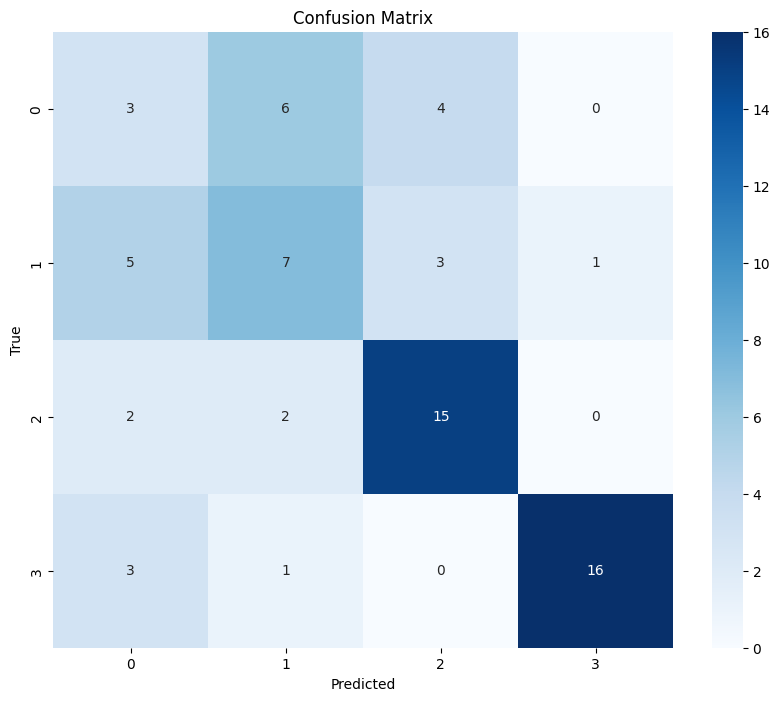

In [66]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [61]:
# fine_tuning
model_ft = build_inception_model(
    img_shape = img_shape,
    meta_features_num=meta_features_num,
    num_classes=num_classes,
    fine_tune=True,
    fine_tune_at=200
)

In [62]:
model_ft.fit(
    train_ds,
    validation_data = val_ds,
    class_weight = class_weights,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.2958 - loss: 3.5794 - val_accuracy: 0.3699 - val_loss: 2.6071
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.3931 - loss: 2.0375 - val_accuracy: 0.3699 - val_loss: 2.3373
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3962 - loss: 1.5201 - val_accuracy: 0.4384 - val_loss: 2.1364
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5166 - loss: 1.2940 - val_accuracy: 0.3425 - val_loss: 2.6107
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5687 - loss: 1.0557 - val_accuracy: 0.3699 - val_loss: 3.9555
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5404 - loss: 1.0221 - val_accuracy: 0.4521 - val_loss: 5.9271
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6007 - loss: 1.0503 - val_accuracy: 0.4247 - val_loss: 3.7470
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6157 - loss: 0.9221 - val_accuracy: 0.3699 - val_loss: 7.3410
Epoch 9/

In [ ]:
test_loss, test_acc = model_ft.evaluate(test_ds)
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

val_loss, val_acc = model_ft.evaluate(val_ds)
print(f"validation loss: {val_loss:.4f}, validation accuracy: {val_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 812ms/step - accuracy: 0.5303 - loss: 2.0151
test loss: 1.96, test accuracy: 0.53
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 890ms/step - accuracy: 0.4340 - loss: 1.9618
validation loss: 1.9605, validation accuracy: 0.5294


In [69]:
# Get predicted class indices
y_pred_prob = model_ft.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 827ms/step
              precision    recall  f1-score   support

           0       0.40      0.15      0.22        13
           1       0.34      0.75      0.47        16
           2       0.71      0.53      0.61        19
           3       0.86      0.60      0.71        20

    accuracy                           0.53        68
   macro avg       0.58      0.51      0.50        68
weighted avg       0.61      0.53      0.53        68



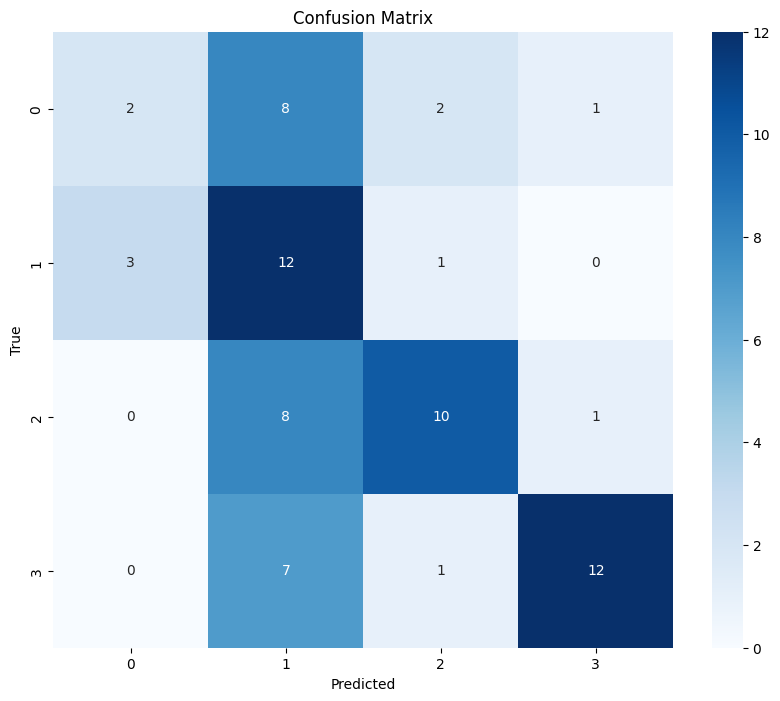

In [70]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()